# **LSTMs: From GRU Memory Limitation to Long-Term Memory Design**

In a GRU, memory is carried by the hidden state $h_t$.
The update rule is given by:

$$h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t$$

If we simplify this expression, we obtain:

$$h_t = z_t (\tilde{h}_t - h_{t-1}) + h_{t-1}$$

Here, the **new memory** is $h_t$ and the **previous memory** is $h_{t-1}$.
This can be interpreted as:

$$\text{new memory} = \text{old memory} + \text{some change}$$

However, an important issue appears at this point.
Even when the update gate is very small, for example $z_t = 0.00001$ (intuitively meaning “do not update the old memory”), the equation still produces:

$$\text{new memory} = 0.99999 \cdot h_{t-1}$$

This means that only **99.999%** of the previous memory is retained.
After many time steps, this multiplicative decay compounds:

$$(0.99999)^{100}$$

As a result, some critical information is gradually lost.
This explains why, for long sequences, the GRU design struggles to retain memory over very long time spans.

Observing the equation again:

$$h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t$$

we see that **both memory removal and memory update are controlled by a single gate**, $z_t$.
This coupled control motivates the design change introduced in LSTM, where these responsibilities are split for better manipulation of memory.

---

## **Solution: Redesigning Memory Update**

The goal is to update memory such that:

* **100% of the old memory can be retained**
* the update is **linear**, so no forced decay of old information occurs
* the flow of information remains fully controlled by the neural network

The update must satisfy:

$$\text{new memory} = \text{old memory} \quad \text{(must be possible)}$$

and also allow:

$$\text{new memory} = \text{old memory} + \text{some information}$$

where this new information depends on the current input and the current context.

Introducing gating control, this formulation becomes:

$$\text{new memory} = f_t \cdot \text{old memory} + i_t \cdot g_t$$

This is the **long-term memory** formulation, answering what happened many time steps earlier.

The **current hidden state** is then defined as:

$$\text{current hidden state} = o_t \cdot \tanh(\text{new memory})$$

which represents **short-term memory**, answering what happened most recently.

---

## **Gate Definitions and Roles**

* $f_t$ → forget gate
* $i_t$ → input gate
* $g_t$ → candidate gate
* $o_t$ → output gate

The long-term memory is defined as:

$$c_t = f_t \cdot c_{t-1} + i_t \cdot g_t$$

This guarantees that **100% retention of old memory is possible across any time step**, with a linear update mechanism.

---

### **Forget Gate**

$$f_t = \sigma(W x + U h_{t-1} + b)$$

Given the current input $x$ and previous context $h_{t-1}$, this gate analyzes which information from $c_{t-1}$ should be kept.

---

### **Input Gate**

$$i_t = \sigma(W x + U h_{t-1} + b)$$

This gate determines **how much new information** is added to the old memory.
It only controls the **strength** of the update.
The actual content to be written is decided by $g_t$.

Thus:

$$i_t \cdot g_t$$

represents the update applied to the long-term memory.

---

### **Candidate Gate**

$$g_t = \tanh(W x + U h_{t-1} + b)$$

Given the current input and previous context, this gate determines **what new information should be stored** in long-term memory.

The use of `tanh` keeps the candidate memory **bounded and stable**, while the strength of the update is controlled by $i_t$.

---

## **Long-Term Memory Update**

$$c_t = f_t \cdot c_{t-1} + i_t \cdot g_t$$

* $f_t$ → how much of the old memory to keep
* $i_t$ → how much new information to add
* $g_t$ → content of the new memory

These two gates were a **single update gate in GRU**, where:

* $(1 - z_t)$ controlled erasure
* $z_t$ controlled update

---

## **From GRU to LSTM (Conceptual Mapping)**

$$(1 - z_t) \rightarrow f_t$$

$$z_t \rightarrow i_t$$

$$h_{t-1} \rightarrow c_{t-1} \quad \text{(long-term memory)}$$

$$\tilde{h}_t \rightarrow g_t$$

**Note:** This mapping is conceptual.
LSTM allows **independent control** of retention and update, which GRU cannot.

---

## **Output Gate and Hidden State**

$$o_t = \sigma(W x + U h_{t-1} + b)$$

Given the current input and recent context, this gate determines **how much of the long-term memory should be exposed**.

The hidden state is then computed as:

$$h_t = o_t \cdot \tanh(c_t)$$

This represents **short-term memory** and is returned as the visible state of the network.


### **Summary**

$$
\begin{aligned}
f_t &= \sigma(W_f x_t + U_f h_{t-1} + b_f) \\
i_t &= \sigma(W_i x_t + U_i h_{t-1} + b_i) \\
g_t &= \tanh(W_g x_t + U_g h_{t-1} + b_g) \\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t \\
o_t &= \sigma(W_o x_t + U_o h_{t-1} + b_o) \\
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$$

### **Notation**

* $\sigma(\cdot)$: sigmoid activation  
* $\tanh(\cdot)$: hyperbolic tangent  
* $\odot$: element-wise (Hadamard) product  
* $W_*, U_*, b_*$: trainable parameters

## Gradient Analysis

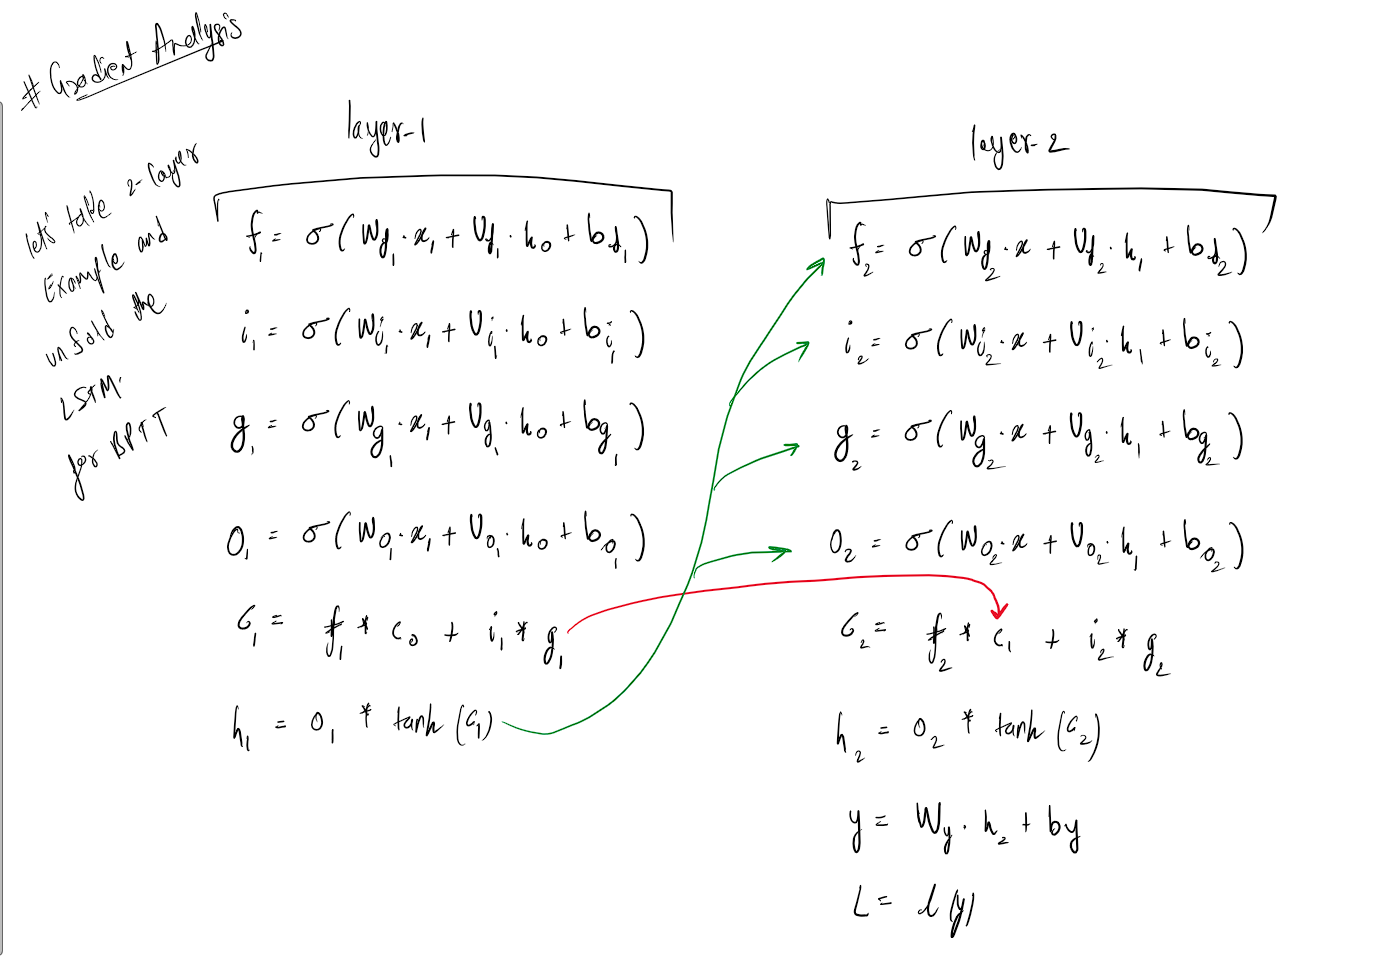

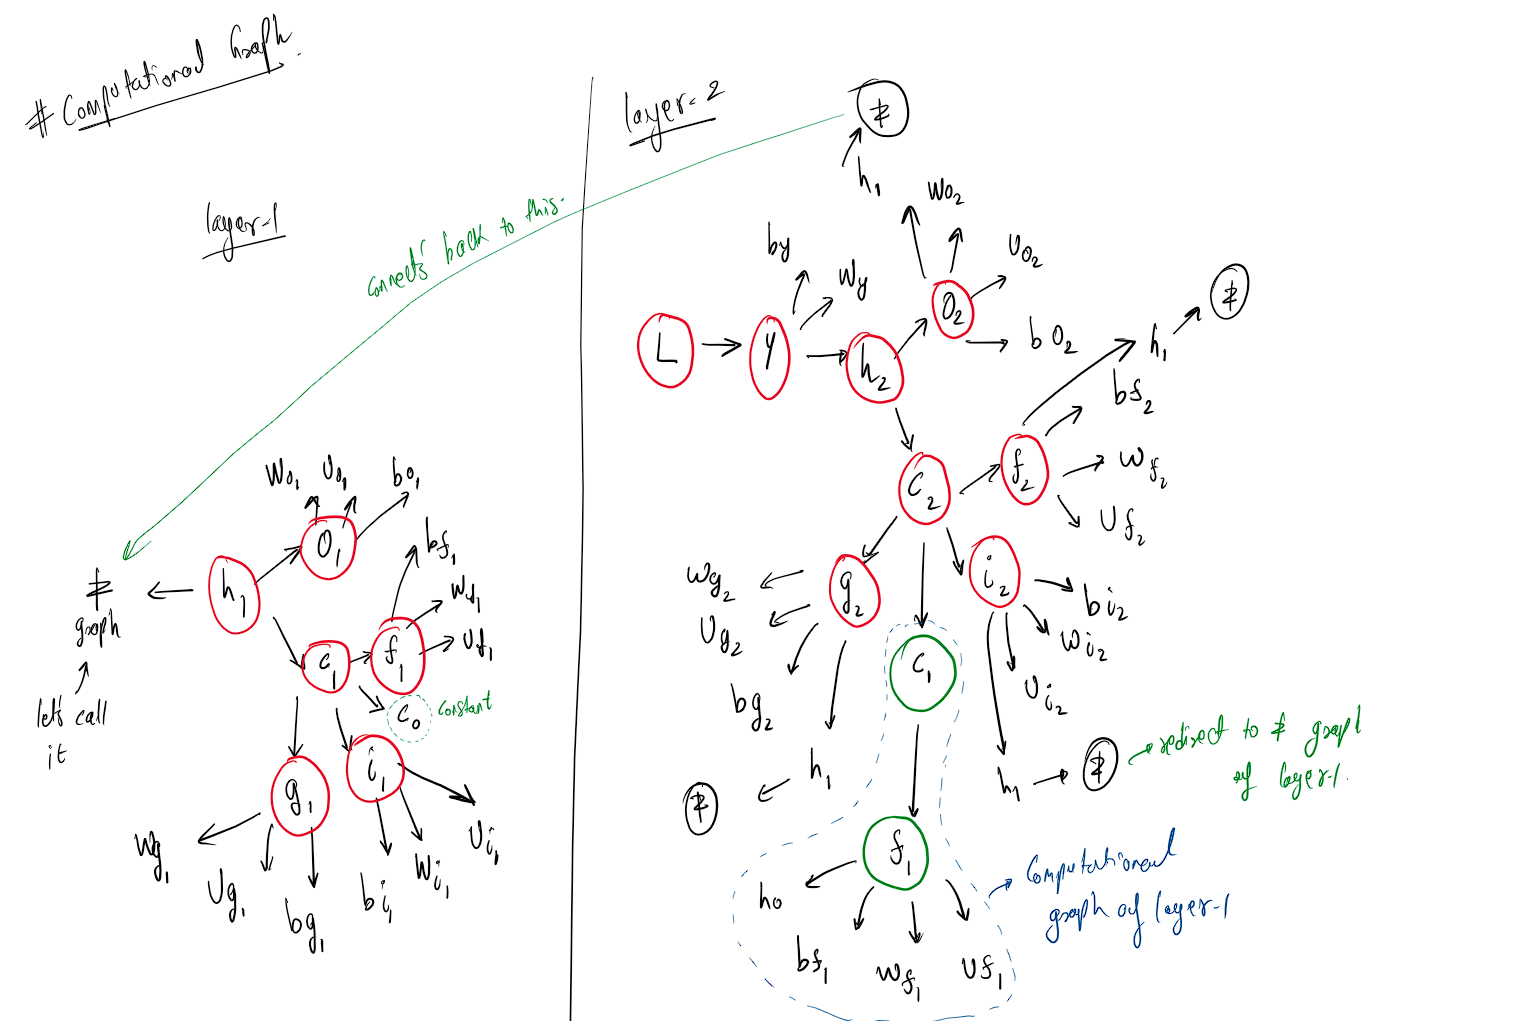

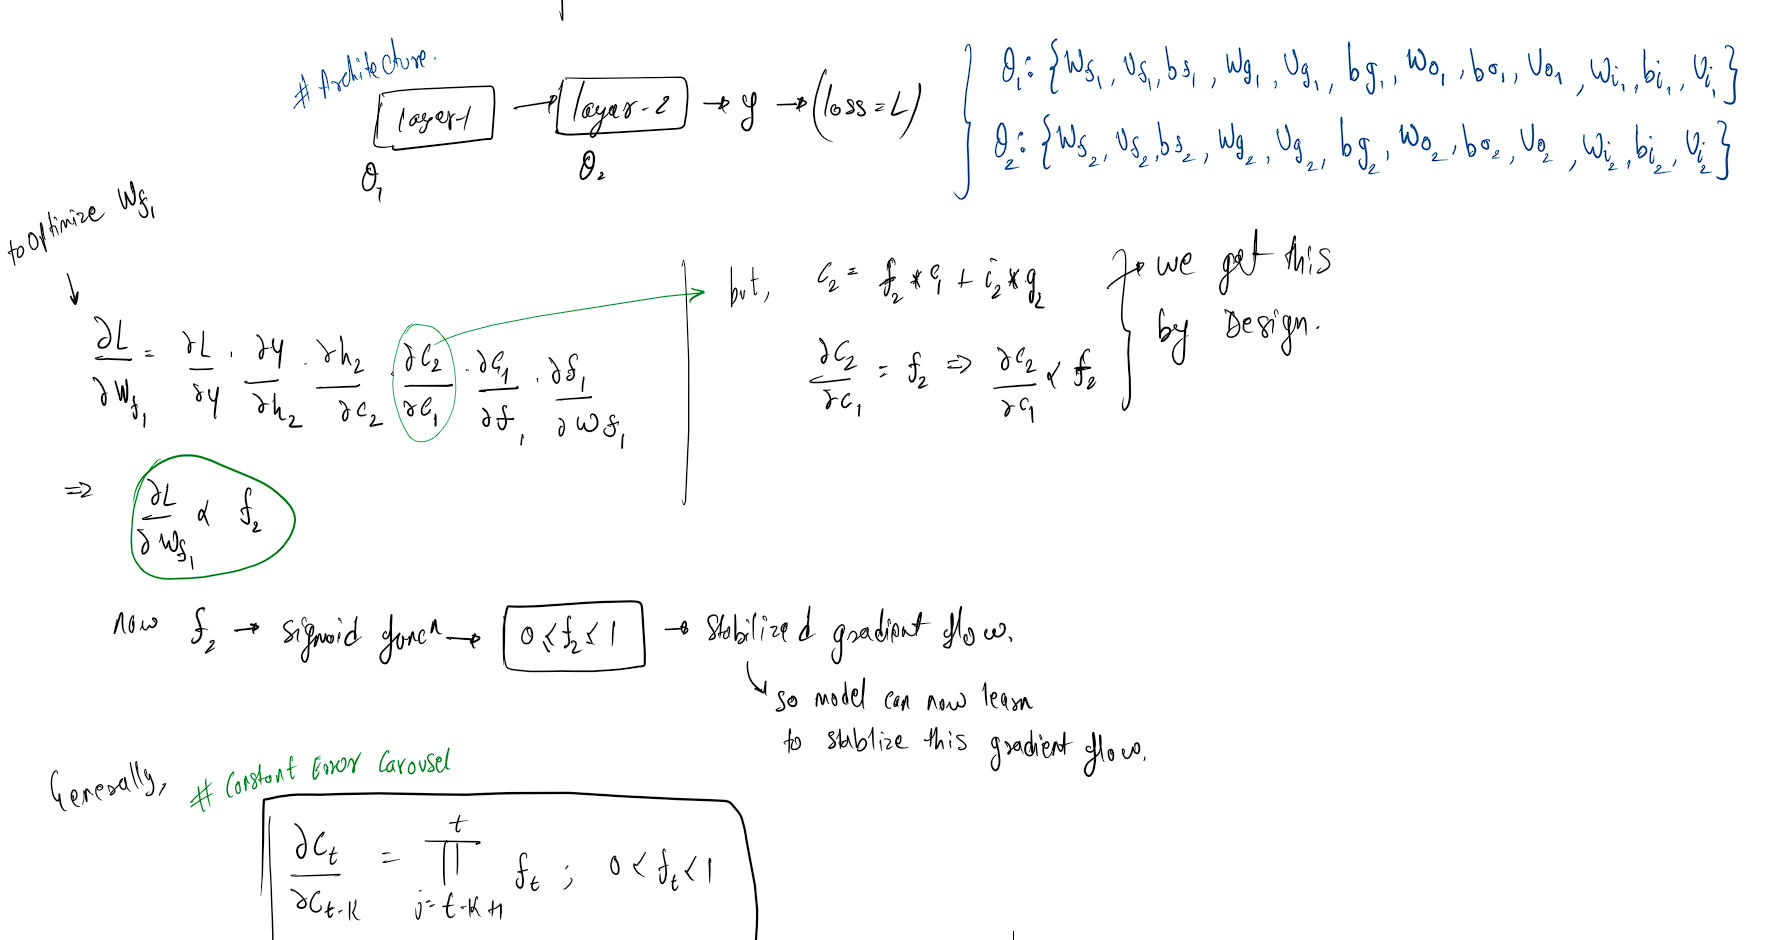

### Building an LSTM From Scratch

$$
\begin{aligned}
f_t &= \sigma(W_f x_t + U_f h_{t-1} + b_f) \\
i_t &= \sigma(W_i x_t + U_i h_{t-1} + b_i) \\
g_t &= \tanh(W_g x_t + U_g h_{t-1} + b_g) \\
c_t &= f_t \odot c_{t-1} + i_t \odot g_t \\
o_t &= \sigma(W_o x_t + U_o h_{t-1} + b_o) \\
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$$


In [1]:
import torch.nn as nn
import torch

In [2]:
class LSTMCell(nn.Module):
    """ 
    This Implementation is Differ from the PyTorch's Official Implementation
    NOTE:
        This is not the official Implementation of PyTorch's GRUcell Because they use 2 biases per Gate
        and i'm only using 1 bias per Gate

        PyTorch's Official Implementation: (2 biases per gate: input bias + hidden bias)
        # f_t = σ(W_if x_t + b_if + W_hf h_{t-1} + b_hf)
        # i_t = σ(W_ii x_t + b_ii + W_hi h_{t-1} + b_hi)
        # g_t = tanh(W_ig x_t + b_ig + W_hg h_{t-1} + b_hg)
        # c_t = f_t ⊙ c_{t-1} + i_t ⊙ g_t
        # o_t = σ(W_io x_t + b_io + W_ho h_{t-1} + b_ho)
        # h_t = o_t ⊙ tanh(c_t)
    """
    def __init__(self, in_features, hidden_dim):
        """
        This Cell is responsible for computing the forward pass of single LSTM call
        Stack this into Layers to get a working LSTMLayers

        We have total of 3 Gates + 1 candidate state

        # Forget gate
        # f_t = σ(W_f x_t + U_f h_{t-1} + b_f)

        # Input gate
        # i_t = σ(W_i x_t + U_i h_{t-1} + b_i)

        # Candidate memory (candidate state)
        # g_t = tanh(W_g x_t + U_g h_{t-1} + b_g)

        # Cell state (long-term memory)
        # c_t = f_t ⊙ c_{t-1} + i_t ⊙ g_t

        # Output gate
        # o_t = σ(W_o x_t + U_o h_{t-1} + b_o)

        # Hidden state (short-term memory)
        # h_t = o_t ⊙ tanh(c_t)

        """
        super().__init__()
        self.in_features = in_features
        self.hidden_dim = hidden_dim

        # Forget Gate
        self.W_f_x = nn.Linear(in_features = self.in_features, out_features = self.hidden_dim, bias = False)
        self.W_f_h = nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, bias = False)
        self.b_f = nn.Parameter(torch.ones(self.hidden_dim))

        # Input Gate
        self.W_i_x = nn.Linear(in_features = self.in_features, out_features = self.hidden_dim, bias = False)
        self.W_i_h = nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, bias = False)
        self.b_i = nn.Parameter(torch.zeros(self.hidden_dim))

        # Output Gate
        self.W_o_x = nn.Linear(in_features = self.in_features, out_features = self.hidden_dim, bias = False)
        self.W_o_h = nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, bias = False)
        self.b_o = nn.Parameter(torch.zeros(self.hidden_dim))

        # Candidate State
        self.W_g_x = nn.Linear(in_features = self.in_features, out_features = self.hidden_dim, bias = False)
        self.W_g_h = nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, bias = False)
        self.b_g = nn.Parameter(torch.zeros(self.hidden_dim))
    
    def forward(self, x, h_prev, c_prev):
        # Calculate candidate cell state
        g_t = torch.tanh(self.W_g_x(x) + self.W_g_h(h_prev) + self.b_g)
        i_t = torch.sigmoid(self.W_i_x(x) + self.W_i_h(h_prev) + self.b_i)
        f_t = torch.sigmoid(self.W_f_x(x)  +self.W_f_h(h_prev) + self.b_f)
        c_t = f_t * c_prev + i_t * g_t # Long Term Memory
        o_t = torch.sigmoid(self.W_o_x(x) + self.W_o_h(h_prev) + self.b_o)
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t

In [3]:
class LSTMLayer(nn.Module):
    def __init__(self, in_features, hidden_dim, n_layers: int):
        super().__init__()
        self.in_features = in_features
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            self.layers.append(
                LSTMCell(
                    in_features = self.in_features if i == 0 else self.hidden_dim,
                    hidden_dim = self.hidden_dim
                )
            )

    def forward(self, x, h_prev = None, c_prev = None):
        batch_dim, seq_length, _ = x.shape # x.shape = batch_dim, seq_length, embd_dim
        if h_prev is None:
            h_prev = torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device = x.device)
        if c_prev is None:
            c_prev = torch.zeros(self.n_layers, batch_dim, self.hidden_dim, device = x.device)

        outputs = []
        for t in range(seq_length):
            x_t = x[:, t, :]
            new_h = []
            new_c = []
            for layer_idx, cell in enumerate(self.layers):
                h, c = cell(x_t, h_prev[layer_idx], c_prev[layer_idx])
                new_h.append(h)
                new_c.append(c)
                x_t = h
            
            h_prev = torch.stack(new_h, dim=0)
            c_prev = torch.stack(new_c, dim=0)
            outputs.append(x_t)
        outputs = torch.stack(outputs, dim=1)
        return outputs, (h_prev, c_prev)

In [4]:
class LinearLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.linear_projection = nn.Linear(
            in_features=self.in_features,
            out_features=self.out_features,
            bias=True
        )
    
    def forward(self, x):
        return self.linear_projection(x)

In [5]:
class MyLSTMModel(nn.Module):
    def __init__(self, model_name: str, n_layers: int, vocab_size: int, in_features: int, hidden_dim: int, dropout: float):
        super().__init__()
        self.model_name = model_name
        self.vocab_size = vocab_size
        self.in_features = in_features
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.linear_projection = LinearLayer(in_features = self.hidden_dim, out_features = self.vocab_size)
        self.lstm_layer = LSTMLayer(
            in_features = in_features,
            hidden_dim = hidden_dim,
            n_layers = n_layers
        )
        self.layer_norm = nn.LayerNorm(self.hidden_dim)
        
        self.embeddings = nn.Embedding(self.vocab_size, self.in_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, h_prev = None, c_prev = None):
        x_embd = self.embeddings(x) # ---> shape = (batch, seq_length, embd_dim)
        outputs, (h_n, c_n) = self.lstm_layer(x = x_embd,
                                h_prev = h_prev,
                                c_prev = c_prev
        )
        last_layer_output = outputs # for Language Modeling we are only interested in last layer's output,
                                    # its like saying: "Give me the most processed understanding of the sequence.""
        last_layer_out = self.dropout(last_layer_output)
        last_layer_out_norm = self.layer_norm(last_layer_out)
        logits = self.linear_projection(last_layer_out_norm)
        return logits, (h_n, c_n)

## Preparing the Dataset

In [6]:
import torch
import torch.nn as nn


text = open("tiny_shakespeare.txt", 'r', encoding='utf-8').read()

chars = sorted(list(set(text)))
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for c, i in stoi.items()}

data = torch.tensor([stoi[c] for c in text], dtype=torch.long)
seq_length = 128  # sequence length

n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split='train', batch_size=64):
    source = train_data if split == 'train' else val_data
    ix = torch.randint(len(source) - seq_length - 1, (batch_size,))
    X = torch.stack([source[i:i+seq_length] for i in ix])
    Y = torch.stack([source[i+1:i+seq_length+1] for i in ix])
    return X, Y

## Function for Training the Model

In [7]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

def train_model(
        model: MyLSTMModel,
        optimizer,
        scheduler,
        loss_fn,
        epochs,
        batch_size,
        device,
        clip_value=1.0,
        val_interval=1,
        steps = 200
    ):
    
    print(f"\n---------------- Training Started for {model.model_name} Model ----------------\n")
    # steps ---> How many batches will get involve in forwardpass and backward pass
    # steps = 200, and batch_size = 64 meaning 200 batches of each size = 64 will get involved in forwardpass and backward pass
    # 200 * 64 * seq_length = 200 * 64 * 128 = 1.64M tokens/epoch for forward pass and 1.46M token/epoch for backward pass
    # so for larger models, keep larger steps, for Astra-gamma step = 400 

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for _ in range(steps):
            X, Y = get_batch(split="train", batch_size=batch_size)
            X, Y = X.to(device), Y.to(device)

            optimizer.zero_grad()

            logits, _ = model(X)
            loss = loss_fn(
                logits.reshape(-1, logits.size(-1)),
                Y.reshape(-1)
            )

            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            train_loss += loss.item()

        train_loss /= steps

        # Validation
        val_loss = None
        if epoch % val_interval == 0:
            model.eval()
            with torch.no_grad():
                Xv, Yv = get_batch(split="val", batch_size=batch_size)
                Xv, Yv = Xv.to(device), Yv.to(device)

                logits, _ = model(Xv)
                val_loss = loss_fn(
                    logits.reshape(-1, logits.size(-1)),
                    Yv.reshape(-1)
                ).item()

        # Lr Scheduler
        scheduler.step()

        # Epoch and Loss Details
        if val_loss is not None:
            print(f"Epoch {epoch:02d}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch:02d}/{epochs} | Train Loss: {train_loss:.4f}")

    print(f"\n---------------- Training Completed for {model.model_name} Model ----------------\n")
    return model

## Sampling Code

In [8]:
import torch
import torch.nn.functional as F

def sample_greedy(model, stoi, itos, start_text="A", max_new_tokens=200):
    model.eval()
    device = next(model.parameters()).device

    input_ids = torch.tensor([stoi[c] for c in start_text], dtype=torch.long).unsqueeze(0).to(device)

    h, c = None, None

    for _ in range(max_new_tokens):
        logits, (h, c) = model(input_ids[:, -1:], h, c)
        h, c = h.detach(), c.detach()
        next_id = torch.argmax(logits[:, -1, :], dim=-1)
        input_ids = torch.cat([input_ids, next_id.unsqueeze(1)], dim=1)

    return ''.join(itos[i] for i in input_ids[0].tolist())



def sample_with_temperature(model, stoi, itos, start_text="A", max_new_tokens=200, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device

    input_ids = torch.tensor([stoi[c] for c in start_text], dtype=torch.long).unsqueeze(0).to(device)

    h, c = None, None

    for _ in range(max_new_tokens):
        logits, (h, c) = model(input_ids[:, -1:], h, c)
        h, c = h.detach(), c.detach()
        logits = logits[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        input_ids = torch.cat([input_ids, next_id], dim=1)

    return ''.join(itos[i] for i in input_ids[0].tolist())



def sample_top_k(model, stoi, itos, start_text="A", max_new_tokens=200, k=20, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device

    input_ids = torch.tensor([stoi[c] for c in start_text], dtype=torch.long).unsqueeze(0).to(device)

    h, c = None, None

    for _ in range(max_new_tokens):
        logits, (h, c) = model(input_ids[:, -1:], h, c)
        h, c = h.detach(), c.detach()
        logits = logits[:, -1, :] / temperature

        topk_vals, topk_idx = torch.topk(logits, k)
        probs = F.softmax(topk_vals, dim=-1)
        sampled_idx = torch.multinomial(probs, num_samples=1)
        next_id = topk_idx.gather(-1, sampled_idx)

        input_ids = torch.cat([input_ids, next_id], dim=1)

    return ''.join(itos[i] for i in input_ids[0].tolist())


## Function for Saving the Model

In [9]:
    # def __init__(self, model_name: str, n_layers: int, vocab_size: int, in_features: int, hidden_dim: int, dropout: float):
    #     super().__init__()
    #     self.model_name = model_name
    #     self.vocab_size = vocab_size
    #     self.in_features = in_features
    #     self.hidden_dim = hidden_dim
    #     self.n_layers = n_layers
    #     self.linear_projection = LinearLayer(in_features = self.hidden_dim, out_features = self.vocab_size)
    #     self.lstm_layer = LSTMLayer(
    #         in_features = in_features,
    #         hidden_dim = hidden_dim,
    #         n_layers = n_layers
    #     )
    #     self.layer_norm = nn.LayerNorm(self.hidden_dim)
        
    #     self.embeddings = nn.Embedding(self.vocab_size, self.in_features)
    #     self.dropout = nn.Dropout(dropout)

In [10]:
import os
import json
import torch
from datetime import datetime

def save_model(model: MyLSTMModel, base_name="leviathan", path="./leviathan_saved_model/"):
    os.makedirs(path, exist_ok=True)

    # versioning
    existing = [f for f in os.listdir(path) if f.startswith(base_name) and f.endswith(".pth")]
    versions = []
    for f in existing:
        parts = f.replace(".pth", "").split("_v")
        if len(parts) == 2 and parts[1].isdigit():
            versions.append(int(parts[1]))
    next_version = max(versions, default=0) + 1

    filename = f"{base_name}_v{next_version}.pth"
    save_path = os.path.join(path, filename)

    checkpoint = {
        "state_dict": model.state_dict(),
        "model_class": model.__class__.__name__,
        "model_name": model.model_name,
        "in_features": model.in_features,
        "hidden_dim": model.hidden_dim,
        "dropout": model.dropout.p,
        "vocab_size": model.vocab_size,
        "n_layers": model.n_layers,
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "version": next_version,
    }

    torch.save(checkpoint, save_path)
    torch.save(checkpoint, os.path.join(path, f"{base_name}_latest.pth"))

    print(f"\nModel saved at: {save_path}")
    print(f"Also updated: {base_name}_latest.pth\n")
    return save_path

## Function for Loading the Model

In [11]:
import torch

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def load_model(filepath, device):
    checkpoint = torch.load(filepath, map_location=device)

    # extract architecture parameters from checkpoint
    model_name  = checkpoint["model_name"]
    vocab_size  = checkpoint["vocab_size"]
    in_features    = checkpoint["in_features"]
    hidden_dim  = checkpoint["hidden_dim"]
    dropout     = checkpoint["dropout"]
    n_layers     = checkpoint["n_layers"]

    # print("------------------------------- dropout = ", dropout)

    # instantiate model using all saved metadata
    model = MyLSTMModel(
        model_name = model_name,
        n_layers = n_layers,
        vocab_size = vocab_size,
        in_features = in_features,
        hidden_dim = hidden_dim,
        dropout    = dropout
    ).to(device)

    # load weights
    model.load_state_dict(checkpoint["state_dict"])

    # pretty print metadata
    print("\n================ MODEL LOADED ================")
    print(f"Loaded File      : {filepath}")
    print(f"Model Name       : {model_name}")
    print(f"Model Class      : {checkpoint['model_class']}")
    print(f"Version          : v{checkpoint['version']}")
    print(f"Timestamp        : {checkpoint['timestamp']}")
    print("----------------------------------------------")

    print("Model Architecture:")
    for name, module in model.named_modules():
        if name != "":
            print(f"  └── {name}: {module.__class__.__name__}")
    print("----------------------------------------------")

    print(f"Total Parameters : {count_parameters(model):,}")
    print(f"Loaded on Device : {device}")
    print("==============================================\n")

    return model

## Function for Printing the Sumamry of the Model

In [12]:
def print_model_summary(model, model_name, epochs, lr, device):
    print("\n" + "="*100)
    print("Leviathan-LSTM MODEL SUMMARY")
    print("="*100)
    print(f"Model Name       : {model_name}")
    print(f"Device           : {device}")
    print(f"Total Epochs     : {epochs}")
    print(f"Learning Rate    : {lr}")

    print("\nMODEL ARCHITECTURE")
    print("-"*100)
    for name, module in model.named_modules():
        if name == "":
            continue
        print(f"  └── {name}: {module.__class__.__name__}()")
    print("-"*100)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = n_params * 4 / (1024**2)

    print(f"\nTrainable Parameters : {n_params:,}")
    print(f"Model Size : {model_size_mb:.2f} MB")

    print("\nPARAMETER BREAKDOWN")
    print("-"*100)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:40s} : {param.numel():,}")

    print("="*100 + "\n")

## Now lets define the architecture and train our Model

In [13]:
# ----------------------------------------------- Define Leviathan-LSTM Architecture  -----------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embd_dim = 768
hidden_dim = 1024
model_name = "Leviathan-LSTM"

leviathan_model = MyLSTMModel(
    model_name = model_name,
    n_layers = 3,
    vocab_size = len(stoi),
    in_features = embd_dim,
    hidden_dim = hidden_dim,
    dropout = 0.2
).to(device)


# ---------------------------------------------------- Training Hyperparameters  --------------------------------------------------
leviathan_model_lr = 1e-3
epochs_leviathan_model = 6
weight_decay_leviathan_model = 0.01

optimizer_large = torch.optim.AdamW(
    leviathan_model.parameters(),
    lr = leviathan_model_lr,
    weight_decay = weight_decay_leviathan_model
)

# CosineAnnealingLR scheduler: cleaner convergence & better text quality
scheduler_large = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_large,
    T_max = epochs_leviathan_model
)

loss_fn = nn.CrossEntropyLoss()

In [14]:
print_model_summary(model = leviathan_model,
                    model_name = model_name,
                    epochs = epochs_leviathan_model,
                    lr = leviathan_model_lr,
                    device=device)


Leviathan-LSTM MODEL SUMMARY
Model Name       : Leviathan-LSTM
Device           : cuda
Total Epochs     : 6
Learning Rate    : 0.001

MODEL ARCHITECTURE
----------------------------------------------------------------------------------------------------
  └── linear_projection: LinearLayer()
  └── linear_projection.linear_projection: Linear()
  └── lstm_layer: LSTMLayer()
  └── lstm_layer.layers: ModuleList()
  └── lstm_layer.layers.0: LSTMCell()
  └── lstm_layer.layers.0.W_f_x: Linear()
  └── lstm_layer.layers.0.W_f_h: Linear()
  └── lstm_layer.layers.0.W_i_x: Linear()
  └── lstm_layer.layers.0.W_i_h: Linear()
  └── lstm_layer.layers.0.W_o_x: Linear()
  └── lstm_layer.layers.0.W_o_h: Linear()
  └── lstm_layer.layers.0.W_g_x: Linear()
  └── lstm_layer.layers.0.W_g_h: Linear()
  └── lstm_layer.layers.1: LSTMCell()
  └── lstm_layer.layers.1.W_f_x: Linear()
  └── lstm_layer.layers.1.W_f_h: Linear()
  └── lstm_layer.layers.1.W_i_x: Linear()
  └── lstm_layer.layers.1.W_i_h: Linear()
  └── 

In [15]:
# ---------------- Train Leviathan-LSTM ----------------

trained_leviathan_model = train_model(
    model = leviathan_model,
    optimizer = optimizer_large,
    scheduler = scheduler_large,
    loss_fn = loss_fn,
    epochs = epochs_leviathan_model,
    batch_size = 64,
    device = device,
    clip_value = 1.0,
    val_interval = 1,
    steps = 200
)



---------------- Training Started for Leviathan-LSTM Model ----------------

Epoch 01/6 | Train Loss: 2.4545 | Val Loss: 1.7801
Epoch 02/6 | Train Loss: 1.5172 | Val Loss: 1.7129
Epoch 03/6 | Train Loss: 1.3635 | Val Loss: 1.6001
Epoch 04/6 | Train Loss: 1.2862 | Val Loss: 1.6344
Epoch 05/6 | Train Loss: 1.2302 | Val Loss: 1.5539
Epoch 06/6 | Train Loss: 1.1935 | Val Loss: 1.4981

---------------- Training Completed for Leviathan-LSTM Model ----------------



## Sampling from the Model

### Greedy Sampling

In [16]:
greedy_text = sample_greedy(
    model = trained_leviathan_model,
    stoi = stoi,
    itos = itos,
    start_text = "A",
    max_new_tokens = 300
)

print("-------- Greedy Sampling -------- ")
print(greedy_text)


-------- Greedy Sampling -------- 
And then the sea that we have seen the seas
And see the sea to the sea to the season of the sea
That thou hast so stand to the sea to the seas,
And then the sea that the state of the season,
And then the sea that the state of the season,
And then the sea that the state of the season,
And then the sea


### Temperature Sampling

In [17]:
temp_text = sample_with_temperature(
    model = trained_leviathan_model,
    stoi = stoi,
    itos = itos,
    start_text = "A",
    max_new_tokens = 300,
    temperature = 0.8
)

print("-------- Temperature Sampling (0.8) -------- ")
print(temp_text)


-------- Temperature Sampling (0.8) -------- 
And then we have a son a friar.

AUTOLYCUS:
I am too: move have from me after, some refuge unto
the cause of me of brother.

KING EDWARD IV:
What send the world hath still she devil that royalty.

PAULINA:
No; for I have say, I do see him; that he
weeping made them at your father's good much.

KING E


### Top-k Sampling

In [23]:
topk_text = sample_top_k(
    model = trained_leviathan_model,
    stoi = stoi,
    itos = itos,
    start_text = "A",
    max_new_tokens = 2000,
    k = 20,
    temperature = 0.8
)

print("-------- Top-K Sampling (k=20, temp=0.8) -------- ")
print(topk_text)


-------- Top-K Sampling (k=20, temp=0.8) -------- 
A:
And look to have. I may be looked in this part
Of trumpets found to search the least better men
That stout of thy sword of them; those are forseal
Shall be the air charges. A father hath
have wound the customer together, though undertake them;
But she be as if you have not mocked forewarr
Since it be abstance, boy.

POLIXENES:
It is a master again of my dearest,
At your eyes like to please your most power.

CORIOLANUS:
And by the which we learn'd the state forfect these
new with eyes to daughter'd your prince,
This is a very of all the news, preverasing
To youthful blood in heart is shall be so
The well-much of thine seasons be pursuit?
O, when I saw the daughter to such a life,
Against the field of the world and heavy day.

KING EDWARD IV:
Away with the bastard news, and nose more sound.

KING RICHARD III:
What are the king like this thing of his hand.

CORIOLANUS:
Why should the state and means to the dead;
And send the palmers of

## Saving the Trained Model

In [19]:
trained_leviathan_model_path = save_model(model = trained_leviathan_model, base_name = "leviathan")


Model saved at: ./leviathan_saved_model/leviathan_v1.pth
Also updated: leviathan_latest.pth



In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_leviathan_model = load_model(filepath = trained_leviathan_model_path, device = device)


================ MODEL LOADED ================
Loaded File      : ./leviathan_saved_model/leviathan_v1.pth
Model Name       : Leviathan-LSTM
Model Class      : MyLSTMModel
Version          : v1
Timestamp        : 2025-12-15 13:26:08
----------------------------------------------
Model Architecture:
  └── linear_projection: LinearLayer
  └── linear_projection.linear_projection: Linear
  └── lstm_layer: LSTMLayer
  └── lstm_layer.layers: ModuleList
  └── lstm_layer.layers.0: LSTMCell
  └── lstm_layer.layers.0.W_f_x: Linear
  └── lstm_layer.layers.0.W_f_h: Linear
  └── lstm_layer.layers.0.W_i_x: Linear
  └── lstm_layer.layers.0.W_i_h: Linear
  └── lstm_layer.layers.0.W_o_x: Linear
  └── lstm_layer.layers.0.W_o_h: Linear
  └── lstm_layer.layers.0.W_g_x: Linear
  └── lstm_layer.layers.0.W_g_h: Linear
  └── lstm_layer.layers.1: LSTMCell
  └── lstm_layer.layers.1.W_f_x: Linear
  └── lstm_layer.layers.1.W_f_h: Linear
  └── lstm_layer.layers.1.W_i_x: Linear
  └── lstm_layer.layers.1.W_i_h: Lin

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_19096\1037960762.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=devi

### Sampling from the Loaded Model

In [21]:
topk_text = sample_top_k(
    model = loaded_leviathan_model,
    stoi = stoi,
    itos = itos,
    start_text = "A",
    max_new_tokens = 300,
    k = 20,
    temperature = 0.8
)

print("-------- Top-K Sampling (k=20, temp=0.8) -------- ")
print(topk_text)


-------- Top-K Sampling (k=20, temp=0.8) -------- 
A:
'Tis a traitor of the man that I would not
this after waeking? there wars I beseecher.

ROMEO:
I shall, deep me: good my lord, is some glistering.

ANGELO:
Yea, and you are for some majesty.

GLOUCESTER:
This first that the seats on Marcius for the moved
As as you come fly for a common king;
Which
